##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import clear_output
# from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.externals import joblib
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass


# def Test(params,X,y,YScaled,XScaled,pool):
#     return(np.random.rand(params['K']))


# def Stats(mse,j,i,params):
#     df = pd.DataFrame(index = [str(j)+'_'+str(i)],
#                       data={'Model':[params['Model']],
#                             'MSE':[mse.mean()],
#                             'SE':[mse.std()/params['K']**.5],
#                             'Performance':0})
#     return(df)

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))


# FirstRun = True
# FirstRun = False
aliases={'wind_speed':'$\overline{U}$','PPFD_Avg':'PPFD',
        'AirTC_Avg':'T$_{a}$','Out_of_Basin':'F$_{out}$',
        'Sedge':'F$_{sdg}$','air_pressure':'P$_{a}$',
        'Shrub':'F$_{shb}$','Sparse':'F$_{spr}$','Grass':'F$_{grs}$'
         ,'Temp':'T$_{s}$','H':'$H$','VPD':'$VPD$','VWC':'$VWC$',
        'Water Table': 'W$_{TBL}$','Active Layer':'AL',
        'Wind Spd':'$\overline{U}$','24H Rain':'24HR','Wtr Tbl Trnd':'d Wtr Tbl',
        'air pressure':'P$_{a}$','Ta':'T$_{a}$','Rn':'Rn','PPFD':'PPFD','Rain':'Rain',
        'Ts 2.5 cm':'T$_{2.5cm}$','Ts 15 cm':'T$_{15cm}$'}


MP=True
Scope = 'Test'
cwd = os.getcwd()
# for Site in ['Illisarvik','FishIsland']:
Site='Illisarvik'
target='fco2'
T= 1#t(0.05,params['K'])

Using TensorFlow backend.


In [2]:
def Performance(ax,title,target):
    ax.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
           yerr=target.level_best['SE'].values*target.SE_Rule,
           color='grey',
        alpha = .8,label='Best model at\neach size')
    ax.bar(target.Best['Size'].values,target.Best['MSE'].values,
           yerr=target.Best['SE'].values*target.SE_Rule,
           color='red',
           alpha = 1,
           label='Parsimony')
    print(target.Best['Model'].values[0],target.Best['MSE'].values[0])
    yaxy = ax.twiny()
    yaxy.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
             yerr=target.level_best['SE'].values*target.SE_Rule,
             color='grey',
             alpha = 0,label=None)
    yaxy.set_xlabel('Number of Factors')
    ax.set_ylabel('MSE')
    ax.set_xlabel('Additional Model Input')
    ax.set_title(title,y=1.1,loc='left')
    plt.sca(ax)
    plt.legend()
    plt.grid()
    plt.xticks(target.level_best['Size'],target.level_best['LastMod'],rotation=90)

# Model

['VWC', 'Sedge']
['F$_{sdg}$', '$VWC$']

['AirTC_Avg', 'VWC', 'Sedge']
['F$_{sdg}$', '$VWC$', 'T$_{a}$']

['AirTC_Avg', 'Temp', 'VWC', 'Grass']
['F$_{sdg}$', '$VWC$', 'T$_{a}$']
['F$_{sdg}$', '$VWC$', 'T$_{a}$', 'F$_{grs}$']

['wind_speed', 'AirTC_Avg', 'Temp', 'VWC', 'Grass']
['F$_{sdg}$', '$VWC$', 'T$_{a}$', 'F$_{grs}$', '$\\overline{U}$']

['F$_{sdg}$', '$VWC$', 'T$_{a}$', 'F$_{grs}$', '$\\overline{U}$']           MSE                                Model  Number  Performance  \
7    0.321425                                Sedge       7            1   
38   0.196144                            VWC+Sedge      26            1   
56   0.152657                  AirTC_Avg+VWC+Sedge       6            1   
87   0.130624             AirTC_Avg+Temp+VWC+Grass      18            1   
121  0.114268  wind_speed+AirTC_Avg+Temp+VWC+Grass      13            1   

           SE  Size Model_Key  
7    0.030093     1       1_7  
38   0.021217     2      2_26  
56   0.016639     3       3_6  
87   0.025

<IPython.core.display.Javascript object>


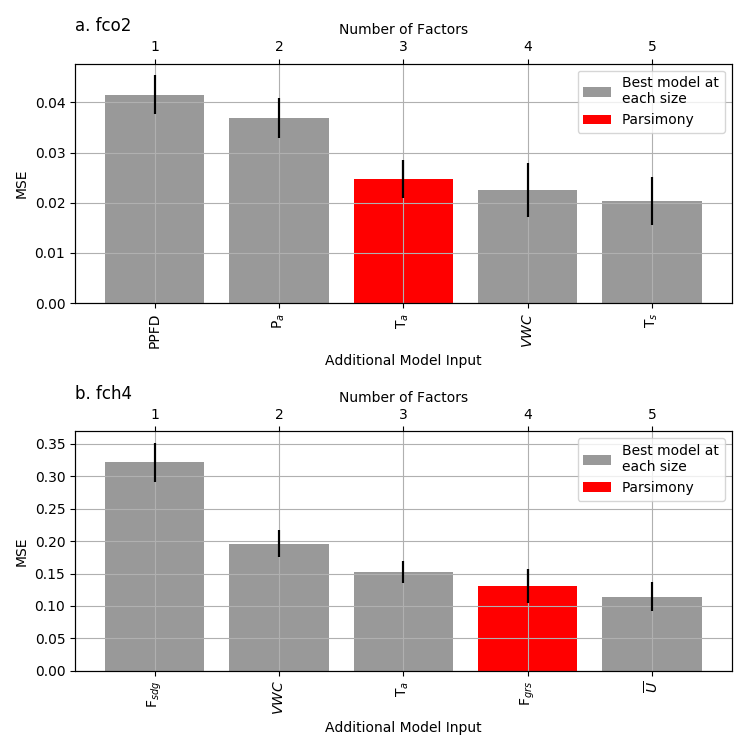

PPFD_Avg+AirTC_Avg+VWC 0.0246701018969
AirTC_Avg+Temp+VWC+Grass 0.130623516714


In [15]:
Project = False
Project = True
Fill = False
# alt_mod=[True]

class ResultMap:
    def __init__(self,target,SE_Rule=1):
        self.SE_Rule = SE_Rule
        self.target = target
        self.params = Dense.Params(Scope,target,MP)
        self.params['Dpath'] = cwd+'/'+Site+'/'
        self.RST = RSTF.ReadStandardTimeFill(self.params,'ECData.csv')#,resample='2H')
        self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
        self.Records['Model_Key']=self.Records['Size'].astype(str)+'_'+self.Records['Number'].astype(str)
        
        Names = []
        for level in self.Records['Size'].unique():
            Level = self.Records.loc[self.Records['Size']==level]
            if level == 1:
                level_best = Level.loc[Level['MSE']==Level['MSE'].min()]
                LastMod=[level_best['Model'].values[0]]
                Names.append(aliases[LastMod[0]])
            else:
                level_best = level_best.append(Level.loc[Level['MSE']==Level['MSE'].min()])
                Mod = level_best.loc[level_best['Size']==level,'Model'].values[0].split('+')
                print(Mod)
                i = 0
                for var in Mod:
                    if var not in LastMod:
                        i += 1
                        if i > 1:
                            l = Names[-1]
                            del Names[-1]
                            print (Names)
#                             Names.append(l+'&'+aliases[var])
                        LastMod.append(var)
                        Names.append(aliases[var])
                print(Names)
                print()
        print(Names,level_best)
        level_best['LastMod']=Names
        self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
        Best = level_best.loc[level_best['MSE']<=self.Min['MSE'].values[0]+self.Min['SE'].values[0]*SE_Rule]
        self.Best = Best.loc[Best['Size']==Best['Size'].min()]
        self.Model_Selection = self.Best.copy()
        self.level_best = level_best
        
    def Project(self,Projector = None,Model = None):
        if Model ==  None:
            self.Model = self.Model_Selection
        else:
            self.Model = Model
        idx = self.Records['Model_Key'].loc[self.Records['Model']==self.Model].values[0]
        self.params['Spath']=(self.params['Dpath']+'/'+self.target+'/'+idx+'/')
        self.params['Inputs'] = self.Model.split('+')
        self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'])
        if Projector != None:
            if Projector['Map'] == None:
                for ip,val in zip(Projector['Assign']['input'],Projector['Assign']['value']):                    
                    self.RST.Data[ip] = val
            else:
                for ip in self.params['Inputs']:
                    self.RST.Data[ip] = self.RST.Data[ip].mean()
                for ip,val in zip(Projector['Map']['input'],Projector['Map']['min'],Projector['Map']['max']):                    
                    self.RST.Data[ip] = val
                
            self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'],Project=True)
            
    def Map(self,Fill=False):
        if Fill == True:
            X = self.RST.X_fill
        else:
            X = self.RST.X
        self.params['Sname']='Y_'
        Y_fill = []
        MSE = []
        pool = Pool(processes=1,maxtasksperchild=75)
        for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),range(self.params['K']))):
            Y = results
            Yold = Y+0
            Y = self.RST.YScaled.inverse_transform(Y)
            if Fill == False:
                mse = (metrics.mean_squared_error(self.RST.y,Y))
                MSE.append(mse)
            Y_fill.append(Y)                       
        pool.close()
        Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
        Y_fill_bar = Y_fill.mean(axis=0)
        if Fill == False:
            self.MSE = np.asanyarray(MSE)
            self.CI = stats.t.ppf(1-0.025,k)*self.MSE.std()/(k)**.5
        
        YStandard = joblib.load(self.params['Spath']+"YVar_scaler.save") 
        self.params['Sname']='Var'
        self.params['Loss']='Boot_Loss'
        pool = Pool(processes=1,maxtasksperchild=75)
        for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),range(1,2))):
            YVar = results
            YVar = self.RST.YvarScaled.inverse_transform(YVar)                    
        pool.close()
        X_back = np.squeeze(self.RST.XScaled.inverse_transform(X))
        
        self.Data_Map = pd.DataFrame(data=X_back,columns=self.params['Inputs'])
        self.Data_Map[self.target] = np.squeeze(Y_fill_bar)
        self.Data_Map['True'] = self.RST.Ytru#.YScaled.inverse_transform(RST.y)
        self.Data_Map['SE'] = 1/(self.params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
        self.Data_Map['Var'] = np.squeeze(YVar)
        self.Data_Map['CI']=stats.t.ppf(1-0.025,self.params['K'])*(self.Data_Map['SE'])**.5
        self.Data_Map['PI']=stats.t.ppf(1-0.025,self.params['K'])*((self.Data_Map['Var']+self.Data_Map['SE'])**.5) 
   
# fco2 = ResultMap('fco2',SE_Rule = 1.0)#.96)
fch4 = ResultMap('fch4',SE_Rule = 1.0)#.96)
fig,ax=plt.subplots(2,1,figsize=(7.5,7.5))
Performance(ax[0],'a. fco2',fco2)
Performance(ax[1],'b. fch4',fch4)
plt.tight_layout()

In [ ]:
print(fch4.params)

In [27]:
# fch4.Select_Model()

In [29]:
class Display:
    def __init__(self,targets,target_names):
    
        self.target_options={}
        self.target_names=target_names
        for target,name in zip(targets,target_names):
            self.target_options[name]=target
        self.i = 0
        self.Reset('b')
        
    def Reset(self,b):
        button2 = widgets.Button(description="Reset")
        display(button2)
        button2.on_click(self.Clear) 
        self.Select('b')
            
        
    def Select(self,b):
        self.target = self.target_options[self.target_names[self.i]]
        print('Select Model for: ',self.target_names[self.i])
        self.size = widgets.IntSlider(
            value=self.target.Best['Size'].values[0],
            min=1,
            max=self.target.level_best['Size'].max(),
            step=1,
            description='Model Size:',
            continuous_update=True,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )
        display(self.size)
        button = widgets.Button(description="Query Models")
        display(button)
        button.on_click(self.Select_Models) 
    
    def Clear(self,b):
        clear_output()
        self.i = 0
        self.Reset('b')
        
    def Select_Models(self,b):
        self.Model_Selection = widgets.Select(
        options=self.target.Records.loc[self.target.Records['Size']==self.size.value,'Model'].values,
        value=self.target.level_best.loc[self.target.level_best['Size']==self.size.value,'Model'].values[0],
        # rows=10,
        layout=Layout(width='100%'),
        description='Model:',
        disabled=False
        )
        display(self.Model_Selection)
               
        button = widgets.Button(description="Analyze This Model")
        display(button)
        button.on_click(self.Choose)
        
    def Choose(self,b):
        self.target.Model_Selection = self.Model_Selection.value
        self.i +=1
        if self.i < len(self.target_names):
            self.Select('b')


Disp = Display([fco2,fch4],['fco2','fch4'])
fco2 = Disp.target_options['fco2']
fch4 = Disp.target_options['fch4']

A Jupyter Widget

Select Model for:  fco2


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Select Model for:  fch4


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

# Map Results

In [35]:
def Plot(ax,Label,target,regressor,color):
    Data = target.Data_Map.sort_values(regressor)#.reset_index()
    ax.scatter(target.RST.Master[regressor],target.RST.Master[target.target],
               edgecolor='black',
               facecolor='white')
    ax.plot(Data[regressor],Data[target.target],
            label= Label + ' \nr^2: '+str(np.round(metrics.r2_score(Data['True'],
                    Data[target.params['target']])**2,3)),
            color = color)   
    ax.fill_between(Data[regressor],
                    Data[target.target]-Data['PI'], 
                    Data[target.target]+Data['PI'],
                    color = color, alpha = 0.4, 
                    label = '95% PI')
#     ax.fill_between(Data[regressor],
#                     Data[target.target]-Data['CI'], 
#                     Data[target.target]+Data['CI'],
#                     color = 'red', alpha = 0.4, 
#                     label = '95% CI')
    ax.legend()


In [36]:
Values = {'wind_speed':[0,5,10],'Colors':['blue','green','red']}

i = 0
print([key for key in Values.keys()])
print([Values[key][i] for key in Values.keys()])
#     print(Values[key][0])
# print(Values.keys()) 

['wind_speed', 'Colors']
[0, 'blue']


<IPython.core.display.Javascript object>


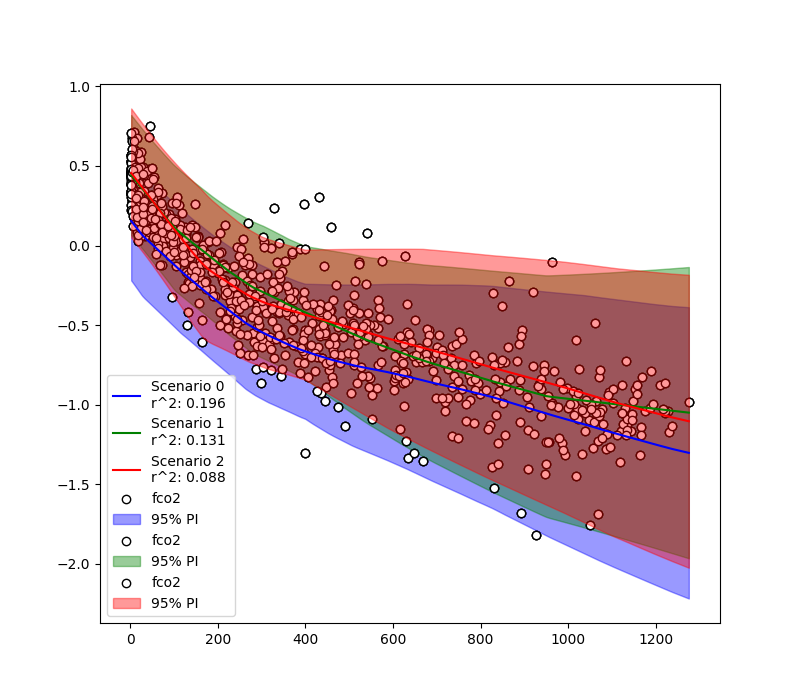

<IPython.core.display.Javascript object>


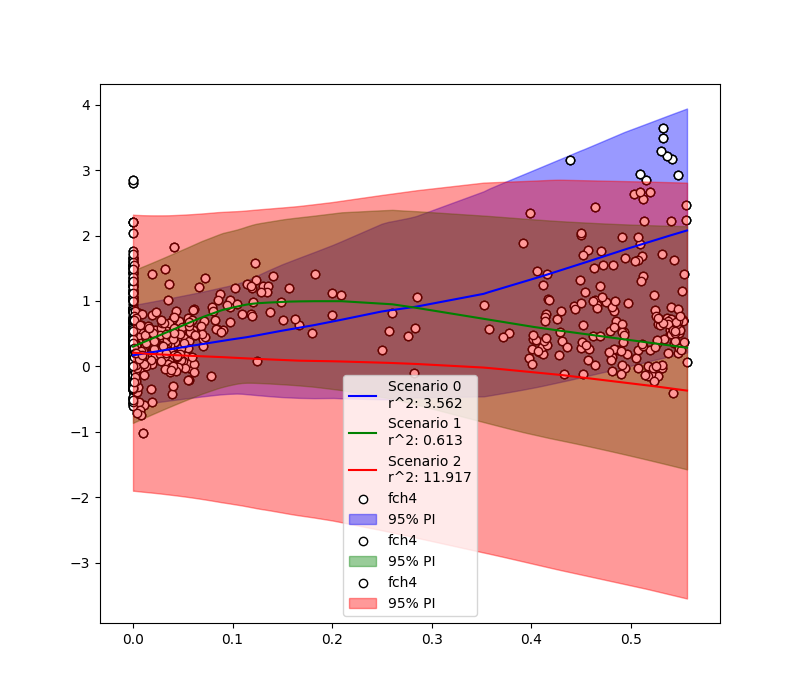

PPFD_Avg+wind_speed
Sedge+wind_speed


In [38]:
fig1,ax1 = plt.subplots(1,1,figsize=(8,7))
fig2,ax2 = plt.subplots(1,1,figsize=(8,7))
for i,color in enumerate(['blue','green','red']):
    Projector = {}
    Projector['Map'] = None
    Projector['Assign'] = {}
    Projector['Assign']['input']=[key for key in Values.keys()]
    Projector['Assign']['value']=[Values[key][i] for key in Values.keys()]
    fco2.Project(Projector = Projector,
                Model = None)
    fch4.Project(Projector = Projector,
                Model = None)
    fco2.Map()
    fch4.Map()
    Plot(ax1,'Scenario '+str(i),fco2,'PPFD_Avg',color)
    Plot(ax2,'Scenario '+str(i),fch4,'Sedge',color)

print(fco2.Model_Selection)
print(fch4.Model_Selection)

In [ ]:
# if Project == False:
#     plt.figure()
#     plt.scatter(RST.y,Y_fill_bar)
#     plt.xlabel('True')
#     plt.ylabel('target')